# Additional preprocessing and some quality check in python (centered ranks)

In [6]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = '/Users/tspisak/projects/PIC_conditioning_withinsub_nodatalad'
pheno = pd.read_csv(base_dir + '/signatures.csv')
ranked_diff = nib.load(base_dir + '/all_data_tranked.nii')
orig_diff = nib.load(base_dir + '/all_data.nii')
mask = nib.load(base_dir + '/full_masked_10_percent.nii')

## Center ranks

In [2]:
# loop through the 4th dimension and rank the data
orig_data = orig_diff.get_fdata()  # get the data  as a numpy array
ranked_data = ranked_diff.get_fdata()  # get the data  as a numpy array
for i in range(orig_data.shape[-1]):
    vol_orig = orig_data[..., i]
    masked_vol_orig = vol_orig[mask.get_fdata() > 0]
    maxneg, minpos = np.max(masked_vol_orig[masked_vol_orig<=0]), np.min(masked_vol_orig[masked_vol_orig>=0])
   
    vol_ranked = ranked_data[..., i]
    masked_vol_ranked = vol_ranked[mask.get_fdata() > 0]
    
    r0 = np.mean((masked_vol_ranked[masked_vol_orig==maxneg], masked_vol_ranked[masked_vol_orig==minpos]))
    vol_ranked[mask.get_fdata() > 0] = masked_vol_ranked - r0
    
# save the centered ranked data
nib.save(nib.Nifti1Image(ranked_data, ranked_diff.affine, ranked_diff.header), '/Users/tspisak/projects/PIC_conditioning_withinsub_nodatalad/all_data_tranked_centered.nii')

## Sanity checks

(2.514312744140625, 96453.0)

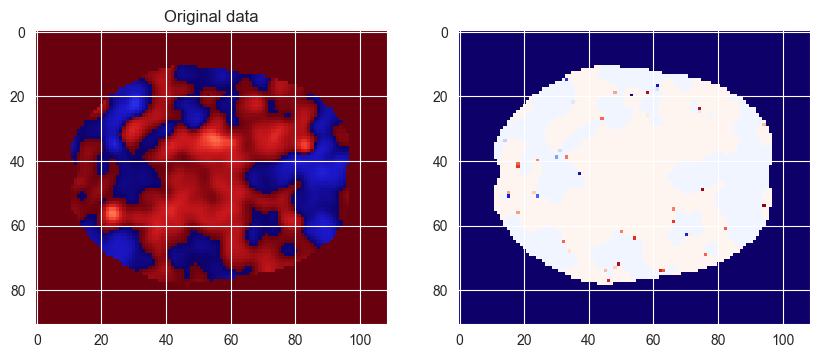

In [7]:
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
# plot the first volume of both the orig and the ramnked centered data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_data[..., 0][:, :, 40], cmap=nilearn_cmaps['blue_red'], vmin=-10, vmax=10)
plt.title('Original data')
plt.subplot(1, 2, 2)
plt.imshow(ranked_data[..., 0][:, :, 40], cmap=nilearn_cmaps['blue_red'], vmin=-1000, vmax=1000)

orig_data[58, 26, 41, 0], ranked_data[58, 26, 41, 0]

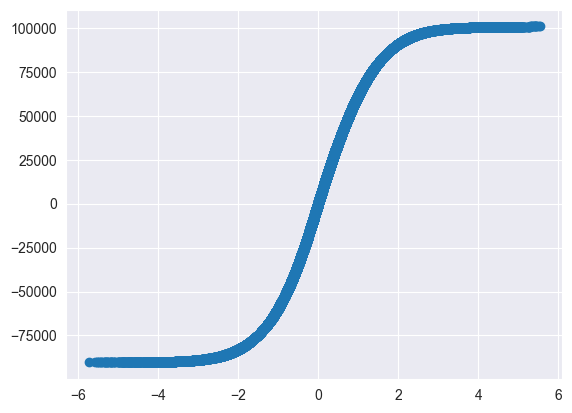

In [8]:
plt.scatter(orig_data[..., 0], ranked_data[..., 0])

<Axes: xlabel='Conditioning', ylabel='ranked_wb_mean'>

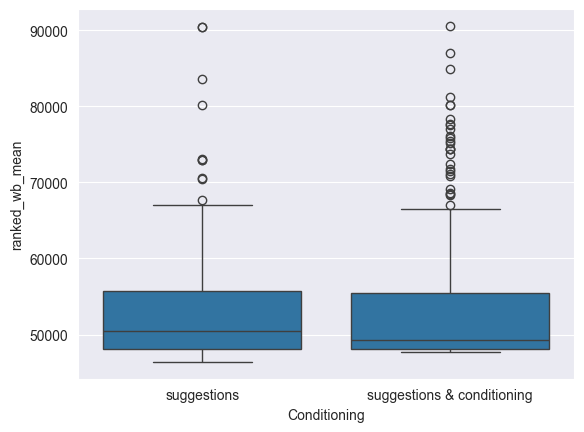

In [19]:
pheno['ranked_wb_mean'] = [np.mean(np.abs(ranked_data[mask.get_fdata() > 0, i])) for i in range(ranked_data.shape[-1])]
sns.boxplot(x='Conditioning', y='ranked_wb_mean', data=pheno)

<Axes: xlabel='Study_ID', ylabel='ranked_wb_mean'>

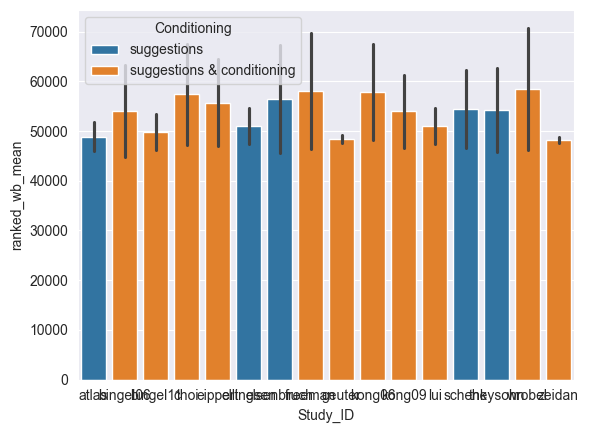

In [28]:
sns.barplot(x='Study_ID', y='ranked_wb_mean', data=pheno, hue='Conditioning', errorbar='sd')

<Axes: xlabel='Conditioning', ylabel='orig_wb_mean'>

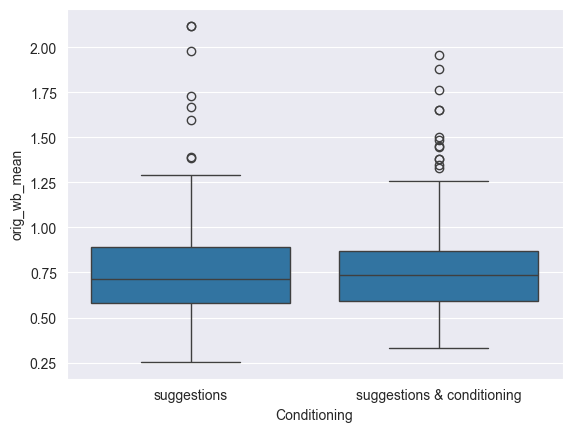

In [21]:
pheno['orig_wb_mean'] = [np.mean(np.abs(orig_data[mask.get_fdata() > 0, i])) for i in range(orig_data.shape[-1])]
sns.boxplot(x='Conditioning', y='orig_wb_mean', data=pheno)

<Axes: xlabel='Study_ID', ylabel='orig_wb_mean'>

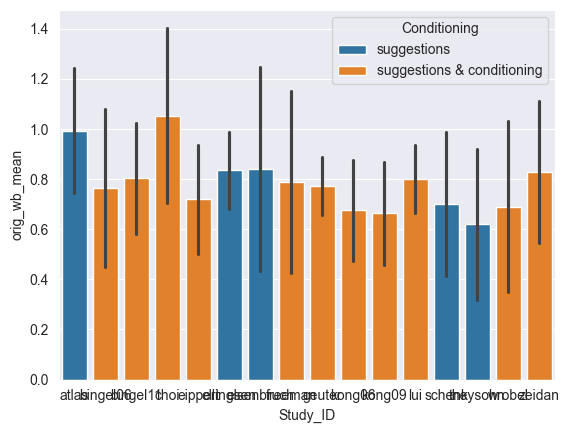

In [29]:
sns.barplot(x='Study_ID', y='orig_wb_mean', data=pheno, hue='Conditioning', errorbar='sd')